# Amazon beauty products recommender system

Recommender system is a class of algorithms and techniques that aims to predict ratings and preferences of users on products. The main application of recommender systems is finding a relationship between users and products in order to maximize the user-product engagement, which is used in a wide range of areas, such as books, movies, songs, news suggestions and other products recommendation in e-commerce in general.

In this notebook, I will build a recommender system for beauty products sold on Amazon.

I will use a dataset related to over 2 Million customer reviews and ratings of Beauty related products sold on their website, containing
the unique user Id (Customer Identification), the product number (Amazon identifier number), ratings (ranging from 1-5 based on customer satisfaction) and
the timestamp of the rating (in UNIX time). 

To save computation time, I reduced the size of the data for a recommender system by randomly sampling approximately 20000 datapoints.

More information on the complete dataset can be found here https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings

<img src="products.jpg" alt="alt text" width="1000"/>

In [1]:
# Import pandas
import pandas as pd
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

## Exploration of the dataset

Let's load the dataset in a data frame and take take a look at it.

In [2]:
# Load the data into a data frame
data=pd.read_csv('data_amazon_beauty.csv') 

In [3]:
# Display the first rows of the dataframe
data.head()

,user_id,product_id,rating,timestamp
0,1417,8472,5,1300924800
1,16542,11890,3,1369180800
2,13313,512,5,1391817600
3,11941,512,5,1367280000
4,8874,512,5,1394582400


We can see that the dataframe contains four columns: user_id, product_id, rating and timestamp. We can drop the timestamp column
since we will not use it for building the recommender system.

In [4]:
# Delete the timestamp column
data.drop(['timestamp'],axis=1,inplace=True)

Let's now check the data type of the variables and the number of NULL values in the data frame.

In [5]:
# Data frame dimentions
data.shape

(20231, 3)

In [6]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20231 entries, 0 to 20230
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   user_id     20231 non-null  int64
 1   product_id  20231 non-null  int64
 2   rating      20231 non-null  int64
dtypes: int64(3)
memory usage: 474.3 KB


The data frame contains 20231 rows and three columns, and all three columns contain 20231 non-null integer 
values. 

Let's further explore the data.

In [7]:
# Count different users in a data frame
data.user_id.value_counts()

0        7
1        6
4        5
3        5
2        5
        ..
12173    1
921      1
12174    1
12175    1
19830    1
Name: user_id, Length: 19831, dtype: int64

In [8]:
# Count different products in a data frame
data.product_id.value_counts()

0        78
1        28
2        24
3        24
4        23
         ..
14304     1
14305     1
14296     1
14306     1
14654     1
Name: product_id, Length: 14655, dtype: int64

In [9]:
# Descriptive statistics
data.describe()

,user_id,product_id,rating
count,20231.000000,20231.000000,20231.000000
mean,9721.826998,5538.250012,4.147002
std,5828.922755,4642.881568,1.310945
min,0.000000,0.000000,1.000000
25%,4657.500000,1126.000000,4.000000
50%,9715.000000,4539.000000,5.000000
75%,14772.500000,9596.500000,5.000000
max,19830.000000,14654.000000,5.000000


We can see that the data frame contains ratings for 14655 different products given by 19831 different users. 
The average rating of the beauty products given by this set of users was around 4.15. We can conclude that
there are no outliers in the raiting column since the maximum rating value is 5 and the minimum raiting value is 1.
These values are in agreement with the rating scale.

Let's check the global rating distribution: what rating was the most popular for the beauty products?

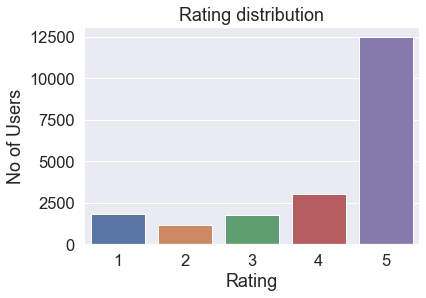

In [10]:
# Plot the barchart to compare the number of times each products were rated with ratings 1,2,3, 4, and 5
sns.set(rc={"figure.figsize":(9, 9)},font_scale=1.5)
fig, ax=plt.subplots()
plt.title('Rating distribution')
sns.countplot(data.rating)
ax.set_ylabel('No of Users')
ax.set_xlabel('Rating')
plt.show()

We can see that that most users rated products with a rating 5, and the least amount of users gave products a rating 2.

## Feature construction for Machine Learning Models

As we have explored the data set, we can now proceed to construct features that will be used by Machine Lerning models to predict
ratings. 

We will create the following 13 features:
    
-**3** global averages : global average of all product ratings, average rating per user, and average rating per product; \
\
-**5** top similar users who rated each product; \
\
-**5** top similar products rated by each user.    

### Split data into train and test datasets

First, let's split the data into train and test sets.

In [11]:
from sklearn.model_selection import train_test_split

# split into train test sets
train_data, test_data = train_test_split(data,random_state=5)

In [12]:
# Check the size of the train and test data sets 
print(train_data.shape)
print(test_data.shape)

(15173, 3)
(5058, 3)


75% of the data will be used to train our models, and 25% of the data will be test data.

### Feature construction for the train data

**Creating sparse matrices from the train and test data frames**

In [13]:
from scipy.sparse import csr_matrix as csrm

# Creating a sparse matrix from the train data
train_sparse_matrix = csrm((train_data.rating.values, (train_data.user_id.values, train_data.product_id.values)))

# Creating a sparse matrix from the test data
test_sparse_matrix = csrm((test_data.rating.values, (test_data.user_id.values, test_data.product_id.values)))

**Global averages**

Now, we will employ the three global average features:
    
-the average ratings of all products given by all users; \
-the average ratings of a particular product given by all users; \
-the average ratings of all products given by a particular user.

In [14]:
# Initialize global average dictionary
train_averages = dict()

# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 4.14815791208067}

Next, let’s create a function which takes the sparse matrix as input and gives the average ratings of a product given by all users, and the average rating of all products given by a single user.

In [15]:
# Function to get the user averages in dictionary (key: user_id/product_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - product axes
    
    # ".A1" is for converting Column_Matrix to 1-D numpy array
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Boolean matrix of ratings ( whether a user rated that product or not)
    is_rated = sparse_matrix!=0
    
    # no of ratings that each user OR product.
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user and max_product ids in sparse matrix
    u,m = sparse_matrix.shape
    
    # create a dictionary of users and their average ratings..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i] !=0}

    #return that dictionary of average ratings
    return average_ratings

In [16]:
# The average ratings of all products given by each user
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)

# Print the average rating of user 3
print('\nAverage rating of user 3 :',train_averages['user'][3])


Average rating of user 3 : 4.4


We have found the average ratings given by each particular user. For example, the average rating
given by user 3 is 4.4

In [17]:
# The average ratings of products given by all users
train_averages['product'] = get_average_ratings(train_sparse_matrix, of_users=False)

# Print the average rating of product 15
print('\n Average rating of product number 15 :',train_averages['product'][15])


 Average rating of product number 15 : 4.153846153846154


We have found the average ratings of each products given by all users. For example, the average rating
of product 15 is around 4.15

In [18]:
from scipy.sparse import find as find

# get users, products and ratings from our samples train sparse matrix
train_users, train_products, train_ratings = find(train_sparse_matrix)

**Features which represent the top 5 similar users and 5 similar products**

Now we will obtain the top 5 similar users who rated a particular product and the top 5 similar products 
rated by a particular user. \
For our calculations, we will use cosine similarity.

In [19]:
# Necessary imports
from sklearn.metrics.pairwise import cosine_similarity

# Create an empty data frame with all the created features
final_data = pd.DataFrame()

count = 0

for (user, product, rating)  in zip(train_users, train_products, train_ratings):
            
            ####    Ratings of "product" by similar users of "user"  ####
            
            # Compute the similar users of the "user" with cosine similarity       
            user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
            
            # We are ignoring 'The User' from its similar users.
            top_sim_users = user_sim.argsort()[::-1][1:] 
            
            # Obtain the ratings of most similar users for this product
            top_ratings = train_sparse_matrix[top_sim_users, product].toarray().ravel()
            
            # Make it's length "5" by adding product averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([train_averages['product'][product]]*(5 - len(top_sim_users_ratings)))
       


            ####   Ratings by "user"  to similar products of "product"   ########
        
            # Compute the similar products of the "product"        
            product_sim = cosine_similarity(train_sparse_matrix[:,product].T, train_sparse_matrix.T).ravel()
            
            # We are ignoring 'The User' from its similar users.
            top_sim_products = product_sim.argsort()[::-1][1:]
            
            # Get the ratings of most similar product rated by this user..
            top_ratings = train_sparse_matrix[user, top_sim_products].toarray().ravel()
            
            # Make it's length "5" by adding user averages to.
            top_sim_products_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_products_ratings.extend([train_averages['user'][user]]*(5-len(top_sim_products_ratings))) 
     

            #####      Prepare the row to be stored in a file         ########
            
            # Create an ampty list fo
            row = list()
            row.append(user)
            row.append(product)
            
            # Now add the other features to this data
            row.append(train_averages['global']) # first feature
            
            # next 5 features are similar_users "product" ratings
            row.extend(top_sim_users_ratings)
            
            # next 5 features are "user" ratings for similar_products
            row.extend(top_sim_products_ratings)
            
            #Add avgerage user rating
            row.append(train_averages['user'][user])
            
            # Add average product rating
            row.append(train_averages['product'][product])

            # Add the actual rating of this user-product pair
            row.append(rating)
            
            count = count + 1
            final_data = final_data.append([row])
            #print(count)
            
            

In [20]:
final_data.columns=['user', 'product', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
            'spr1', 'spr2', 'spr3', 'spr4', 'spr5', 'UAvg', 'PAvg', 'rating']

In [21]:
# Check the first few rows of the ontained train dataset
final_data.head()

,user,product,GAvg,sur1,sur2,sur3,sur4,sur5,spr1,spr2,spr3,spr4,spr5,UAvg,PAvg,rating
0,634,0,4.148158,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.46875,4
0,805,0,4.148158,3.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.46875,5
0,994,0,4.148158,3.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.46875,5
0,1242,0,4.148158,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.46875,4
0,1650,0,4.148158,3.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.46875,5


In [22]:
final_data.shape

(15173, 16)

So, the obtained train data frame contains 15173 rows and 16 columns. 

The coulumns of the obtained data frame are the following:

**GAvg** : The average of all the ratings. \
\
Similar users ratings of this product: \
**sur1**, **sur2**, **sur3**, **sur4**, **sur5** (top 5 similar users who rated that product) \
\
Similar products rated by this user: \
**spr1**, **spr2**, **spr3**,**spr4**, **spr5** (top 5 similar products rated by this user) \
\
**UAvg**  : user’s average rating. \
\
**PAvg** : average rating of this product. \
\
**rating** : rating of this product by this user.

### Repeat the feature construction for the test data

**Global averages in the test data**

As in the case of the train data, we will obtain the following global averages for the test data too:
    
-the average ratings of all products given by all users; \
-the average ratings of a particular product given by all users; \
-the average ratings of all products given by a particular user.

In [23]:
# Global avg of all products by all users

# Set a dictionary for grolabr averages in test date
test_averages = dict()

# Get the global average of ratings in our test set.
test_global_average = test_sparse_matrix.sum()/test_sparse_matrix.count_nonzero()
test_averages['global'] = test_global_average

# Print the global average rating of all products 
test_averages

{'global': 4.143534994068802}

The average rating of all the products in the test data is 4.14

In [24]:
# Average ratings given by a user
test_averages['user'] = get_average_ratings(test_sparse_matrix, of_users=True)

# Print the average rating given by the user 1
print('\nAverage rating of user 1 :',test_averages['user'][1])

# Average ratings given for a product
test_averages['product'] =  get_average_ratings(test_sparse_matrix, of_users=False)

# Print the average rationg of the product 3
print('\nAverage rating of product 3:',test_averages['product'][3])


Average rating of user 1 : 4.666666666666667

Average rating of product 3: 3.857142857142857


You can see that, for instance, the average rating given by user 1 from the test data is arond 4.67 and
the average rating of product 3 is 3.85.

In [25]:
# get users, productss and ratings from our samples test sparse matrix
test_users, test_products, test_ratings = find(test_sparse_matrix)

**Features which represent the top 5 similar users and 5 similar products for the test data**

In [26]:
# Necessary imports
from sklearn.metrics.pairwise import cosine_similarity

# Create an empty data frame with all the created features
final_test_data = pd.DataFrame()

count = 0

for (user, product, rating)  in zip(test_users, test_products, test_ratings):
            
            ####    Ratings of "product" by similar users of "user"  ####
            
            # Compute the similar users of the "user" with cosine similarity       
            user_sim = cosine_similarity(test_sparse_matrix[user], test_sparse_matrix).ravel()
            
            # We are ignoring 'The User' from its similar users.
            top_sim_users = user_sim.argsort()[::-1][1:] 
            
            # Obtain the ratings of most similar users for this product
            top_ratings = test_sparse_matrix[top_sim_users, product].toarray().ravel()
            
            # Make it's length "5" by adding product averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([test_averages['product'][product]]*(5 - len(top_sim_users_ratings)))
       


            ####   Ratings by "user"  to similar products of "product"   ########
        
            # Compute the similar products of the "product"        
            product_sim = cosine_similarity(test_sparse_matrix[:,product].T, test_sparse_matrix.T).ravel()
            
            # We are ignoring 'The User' from its similar users.
            top_sim_products = product_sim.argsort()[::-1][1:]
            
            # Get the ratings of most similar product rated by this user..
            top_ratings = test_sparse_matrix[user, top_sim_products].toarray().ravel()
            
            # Make it's length "5" by adding user averages to.
            top_sim_products_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_products_ratings.extend([test_averages['user'][user]]*(5-len(top_sim_products_ratings))) 
     

            #####      Prepare the row to be stored in a file         ########
            
            # Create an ampty list fo
            row = list()
            row.append(user)
            row.append(product)
            
            # Now add the other features to this data
            row.append(test_averages['global']) # first feature
            
            # next 5 features are similar_users "product" ratings
            row.extend(top_sim_users_ratings)
            
            # next 5 features are "user" ratings for similar_products
            row.extend(top_sim_products_ratings)
            
            #Add avgerage user rating
            row.append(test_averages['user'][user])
            
            # Add average product rating
            row.append(test_averages['product'][product])

            # Add the actual rating of this user-product pair
            row.append(rating)
            
            count = count + 1
            final_test_data = final_test_data.append([row])
        # print(count)
            

In [27]:
# Set the column names for the obtained data frame
final_test_data.columns=['user', 'product', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
            'spr1', 'spr2', 'spr3', 'spr4', 'spr5', 'UAvg', 'PAvg', 'rating']

In [28]:
final_test_data.shape

(5058, 16)

The obtained test data frame contains 5058 rows and 16 columns described above for the case of the train data set.

Now, as we obtained all the necessary features and stored them in a train and test data sets, we can proceed to building Machine Learning models to obtain the final predictions.

## Predictions with XGBoost Regressor

First, we will write a function that we can use to evaluate the performance of our model.
We can do it by calculating Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE). 
RMSE measures the squared loss, while MAPE measures the absolute loss. 
Lower values mean lower error rates and thus better performance.

In [29]:
# Define a function that calculates the model performance metrics - RMSE and Mape
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

First, we need separate the train and test data sets into train and test data containig only feature columns, 
and train and test data only containing the target column (ratings).

In [30]:
# Prepare train X(feature) and y (target) data
x_train = final_data.drop(['user', 'product','rating'], axis=1)
y_train = final_data['rating']

x_test = final_test_data.drop(['user','product','rating'], axis=1)
y_test = final_test_data['rating']

Now, we can define the model and train it on the train dataset

In [31]:
# Define the model and fit it to the train data
import xgboost as xgb

# Set the XGBoost model
xgb_model = xgb.XGBRegressor(n_jobs=13, random_state=5, n_estimators=100)

In [32]:
# Set  dictionaries for storing train and test results
train_results = dict()
test_results = dict()
    
# Fit the model
xgb_model.fit(x_train, y_train, eval_metric = 'rmse')

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=13, num_parallel_tree=1, predictor='auto', random_state=5,
             reg_alpha=0, reg_lambda=1, ...)

**Make predictions on the train and test data frames**

Let's first make predictions on the train data set and store the perfomance metrics (RMSE and MAPE) in a dictionary.

In [33]:
# Get the predictions from the trained model
y_train_pred = xgb_model.predict(x_train)

# Get the RMSE and MAPE of train data
rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
# Store the results in train_results dictionary
train_results = {'rmse': rmse_train,
                    'mape' : mape_train}

Now, we will use the trained model to predict the ratings in the test data.

In [34]:
# Get the test data predictions and compute rmse and mape
y_test_pred = xgb_model.predict(x_test) 

# Calculate test RMSE and MAPE
rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)

# Store the resutls in the test results dictionary.
test_results = {'rmse': rmse_test,
                    'mape' : mape_test}

In [35]:
# Print the model performance metrics
print('Train results:', train_results)
print('Test results:', test_results)

Train results: {'rmse': 0.0012148038855036365, 'mape': 0.005490761125450979}
Test results: {'rmse': 0.006222212067928396, 'mape': 0.008082965766235005}


As we can see, the model performed worse on the test data (as expected), however the RMSE and MAPE values are quite low, which means that the model performed well on the test data.

**Most important features**

The XGBoost library has a built-in function that plots features ordered by their importance.

Let's see which features got the highest feature importance score in our model.

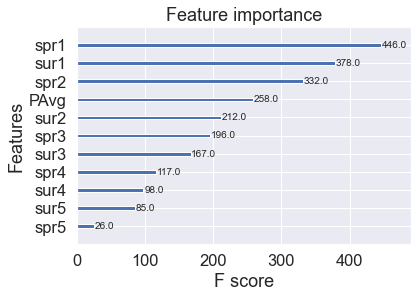

In [36]:
# Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()

You can see from the barchart, the most important features are the top similar product rating and the top similar user rating.

## Predictions with 13 initial features + SVD  matrix factorization

**Matrix factorization with Surprise Library**

Matrix factorization is a calss of collaborative filtering algorithms used in recommender systems. These algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices.

One of such algorithms is **SVD** (Singular Value Decomposition) algorithm, a very popular linear algebra technique to break down a matrix into the product of a few smaller matrices.

The algorithm uses a matrix structure where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users. Note, that we cannot give raw data to train the model in Surprise library. Thus, we need transform the train and test data.

To perform matrix-factorization with SVD we will use the **Surprise** library (the namestands for Simple Python Recommendation System Engine).

We will be able to use the SVD predictions as an additional feature for further modelling.

**SVD on train data**

In [37]:
import surprise
from surprise import SVD
from surprise import Reader, Dataset

# It is to specify how to read the data frame.
reader = Reader(rating_scale=(1,5))

# Load the train_data from the data frame
train_data_mf = Dataset.load_from_df(train_data[['user_id', 'product_id', 'rating']], reader)

# Build the train set from traindata. It is of dataset format from surprise library
trainset = train_data_mf.build_full_trainset()

# Define SVD model
svd = SVD(n_factors=100, biased=True, random_state=5, verbose=True)

# Fit the model to the trainset
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [38]:
#getting predictions of train set
train_preds = svd.test(trainset.build_testset())
train_pred_mf = np.array([pred.est for pred in train_preds])

In [39]:
# Print the predictions
train_pred_mf

array([3.83857084, 4.31410628, 3.0027348 , ..., 4.54104316, 4.48191665,
       4.42643249])

**SVD on test data**

In [40]:
# Load the test_data from the data frame
test_data_mf = Dataset.load_from_df(test_data[['user_id', 'product_id', 'rating']], reader)

# Build the test set from testdata .It is of dataset format from surprise library
testset = test_data_mf.build_full_trainset()

# Define SVD model
svd = SVD(n_factors=100, biased=True, random_state=5, verbose=True)

# Fit the model
svd.fit(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [41]:
# Get predictions of test set
test_preds = svd.test(testset.build_testset())
test_pred_mf = np.array([pred.est for pred in test_preds])

# Print the test data predictions
test_pred_mf

array([4.07558328, 4.28242936, 3.03648192, ..., 4.54647918, 3.09019612,
       3.00963393])

We can now add the ratings predicted by SVD model as an additional feature to train our model on.
Let's see if this can iprove the performance of the model.

**Adding the new feature to the train and test data frames**

In [42]:
train_pred_mf.shape

(15173,)

In [43]:
train_pred_mf.shape

(15173,)

In [44]:
# Add svd feature to the train data
final_data['mf_svd']=train_pred_mf

In [45]:
final_test_data.shape

(5058, 16)

In [46]:
test_pred_mf.shape

(5058,)

In [47]:
# Add svd feature to the test data
final_test_data['mf_svd']=test_pred_mf

Now, we will separate the updated train and test data sets into train and test data containig only feature columns, 
and train and test data only containing the target column (ratings).

In [48]:
# Prepare train X(feature) and y (target) data
x_train = final_data.drop(['user', 'product','rating'], axis=1)
y_train = final_data['rating']

In [49]:
# Prepare test data
x_test = final_test_data.drop(['user','product','rating'], axis=1)
y_test = final_test_data['rating']

Now, we will train the model on the updated train dataset

**Training the XGB Regressor model on the new train data**

In [50]:
# Set  dictionaries for storing train and test results
train_results = dict()
test_results = dict()
    
# Fit the model
xgb_model.fit(x_train, y_train, eval_metric = 'rmse')

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=13, num_parallel_tree=1, predictor='auto', random_state=5,
             reg_alpha=0, reg_lambda=1, ...)

Now, using the trained model, we can get the predictions for the updated train data

**Make predictions on the updated train and test data frames**

In [51]:
# Get the predictions from the trained model
y_train_pred = xgb_model.predict(x_train)

# Get the rmse and mape of train data
rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
# Store the results in train_results dictionary
train_results = {'rmse': rmse_train,
                    'mape' : mape_train,}

Now, we will use the trained model to predict the ratings in the updated test data.

In [52]:
# Get the test data predictions and compute rmse and mape
y_test_pred = xgb_model.predict(x_test) 

rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)

# Store the resutls in the test results dictionary.
test_results = {'rmse': rmse_test,
                    'mape' : mape_test}

In [53]:
# Print the results
print('Train results: ',train_results)

# Print the results
print('Test results:',test_results)

Train results:  {'rmse': 0.001634713584662336, 'mape': 0.010464153855684843}
Test results: {'rmse': 0.011442035428420028, 'mape': 0.02170421160522839}


Interestingly, the RMSE and MAPE values of the model that uses the additional feature are greater than those obrained
when we used only 13 initial features only. This means than the performance of the model is worse when we use the
additional matrix factorization factor. **Adding Collaborative filtering results in worse predictions**.

Let's see which features got the highest feature importance score in this model.

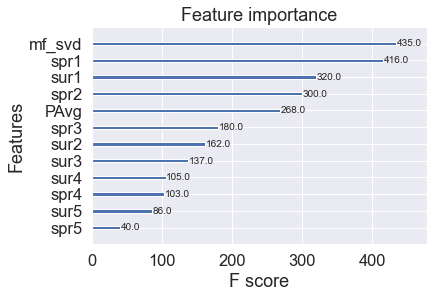

In [54]:
# Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()

As you can see from the barchart, the most important features are the values predicted by svd model
as well as the top similar product rating,and the top similar user rating.